<a href="https://colab.research.google.com/github/yogesh1000/Transfer-Learning-for-COVID-19-cases-and-deaths-forecast-using-LSTM-network/blob/main/multistep_newcases_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving covid new.xlsx to covid new.xlsx


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving italy5.h5 to italy5.h5


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving usa5.h5 to usa5.h5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
model = tf.keras.models.load_model('usa5.h5')
# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
lambda (Lambda)              (None, 5)                 0         
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import pandas as pd
data = pd.read_excel("covid new.xlsx")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

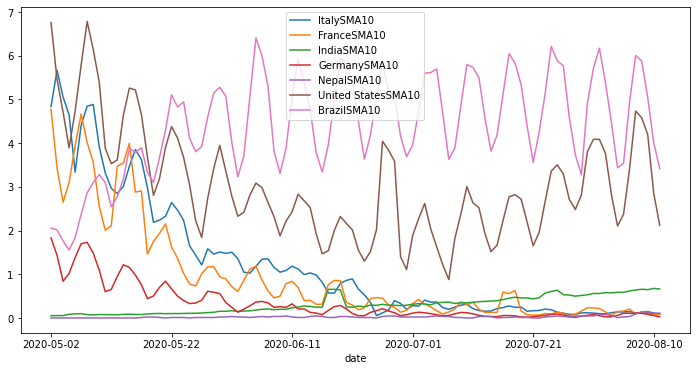

In [ ]:
df1=data[data['location']=='France']
df1.index=df1.date
cols=['new_deaths_per_million']
newdata1=df1[cols]

df2=data[data['location']=='Nepal']
df2.index=df2.date
newdata2=df2[cols]
df3=data[data['location']=='India']
df3.index=df3.date
newdata3=df3[cols]

df4=data[data['location']=='Germany']
df4.index=df4.date
newdata4=df4[cols]
df5=data[data['location']=='United States']
df5.index=df5.date
newdata5=df5[cols]
df6=data[data['location']=='Brazil']
df6.index=df6.date
newdata6=df6[cols]

df=data[data['location']=='Italy']
df.index=df.date
newdata=df[cols]

newdata.rename(columns={'new_deaths_per_million':'Italy'}, inplace=True)
newdata['France']=newdata1
newdata['India']=newdata3
newdata['Germany']=newdata4
newdata['Nepal']=newdata2
newdata['United States']=newdata5
newdata['Brazil']=newdata6

newdata=newdata.tail(104)
remove=newdata.columns
df=newdata
wsize=10

for j in range(0,df.shape[1]):
  newname=str(newdata.columns[j])
  df[newdata.columns[j]+'SMA'+str(wsize)] = df.iloc[:,j].rolling(window=3).mean()
  #for i in range(0,df.shape[0]-2):
    #df.loc[df.index[i+2],newdata.columns[j]+'avg_3'] = np.round(((df.iloc[i,j]
#                                                                 + df.iloc[i+1,j] +df.iloc[i+2,j])/3),1)
df=df.drop(remove,axis=1)
newdata=df.tail(102)
newdata.plot(figsize=(12,6))
    

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i:i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
uni_data = newdata['GermanySMA10']
#uni_data.index = newdata.index
uni_data.head()

val_data=newdata['FranceSMA10']

uni_data = uni_data.values
val_data=val_data.values
univariate_past_history = 20
univariate_future_target = 5

x_train_uni, y_train_uni = univariate_data(uni_data, 0, None,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(val_data, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)
BATCH_SIZE = 110
BUFFER_SIZE = 10

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
for x, y in val_univariate.take(1):
  print (model.predict(x).shape)

(77, 5)


In [ ]:
def root_mean_squared_error(y_true, y_pred):
  y_true=np.array(y_true)
  y_pred=np.array(y_pred)
  return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1))
#print(root_mean_squared_error(real[:,0],test[:,0]))

(77, 5)
1.5160970019348237
1.7918890683516
1.2885907568649524
(77,)
1.337630488655784
1.6550543308258057
1.1380836963653564
(77,)


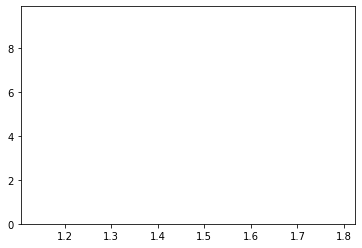

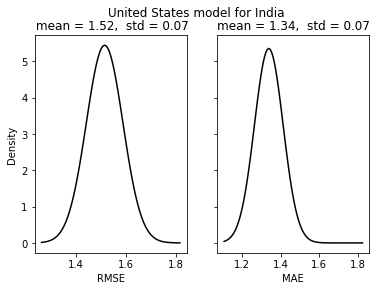

In [ ]:
model = tf.keras.models.load_model('usa5.h5')
val_data=newdata['IndiaSMA10']

val_data=val_data.values
univariate_past_history = 20
univariate_future_target = 5

x_val_uni, y_val_uni = univariate_data(val_data, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)
BATCH_SIZE = 110
BUFFER_SIZE = 10

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

for x, y in val_univariate.take(1):
  print (model.predict(x).shape)

k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
rmse=[]
for x, y in val_univariate.take(1):
  forecasts=model.predict(x)           

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  rmse.append(root_mean_squared_error(real,test))
  maxi=np.append(maxi,root_mean_squared_error(real,test)).max()
  mini=np.append(mini,root_mean_squared_error(real,test)).min()
  sumi=sumi+(root_mean_squared_error(real,test))
print(sumi/k)
print(maxi)
print(mini)
print(np.array(rmse).shape)
from scipy.stats import norm
# Fit a normal distribution to the data:

rmse=np.array(rmse)
murmse, stdrmse = norm.fit(rmse)
plt.hist(rmse, bins=25, density=True, alpha=0, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
xre = np.linspace(xmin, xmax, 100)
prmse = norm.pdf(xre, murmse, stdrmse)


from scipy.stats import norm
# Fit a normal distribution to the data:
k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
maee=[]

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  new=tf.keras.metrics.mean_absolute_error(real,test).numpy()
  maee.append(new)
  maxi=np.append(maxi,new).max()
  mini=np.append(mini,new).min()
  sumi=sumi+(new)


mae=np.array(maee)
mumae, stdmae = norm.fit(mae)
plt.hist(mae, bins=25, density=True, alpha=0, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
xme = np.linspace(xmin, xmax, 100)
pmae = norm.pdf(xme, mumae, stdmae)

print(sumi/k)
print(maxi)
print(mini)
print(np.array(maee).shape)


f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,)  
ax1.plot(xre, prmse,'k')  
ax1.set_title('title')  
ax1.set_xlabel('RMSE')
ax1.set_ylabel('Density')
title = " mean = %.2f,  std = %.2f" % (murmse, stdrmse)
ax1.set_title(title)

ax2.plot(xme, pmae,'k') 
ax2.set_xlabel('MAE')
title = "mean = %.2f,  std = %.2f" % (mumae, stdmae)
ax2.set_title(title)
f.suptitle('United States model for India')
f.savefig('usIndia.jpg')


(77, 5)
0.9577145185148638
2.2441310285677836
0.243244122302079
(77,)
0.8238439391572754
2.14548397064209
0.20402932167053223
(77,)


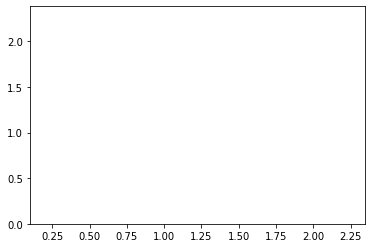

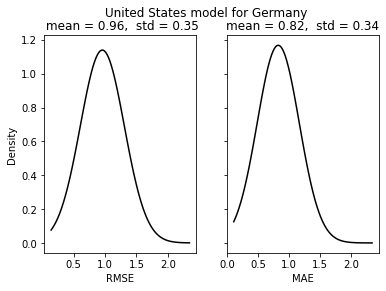

In [ ]:
val_data=newdata['GermanySMA10']

val_data=val_data.values
univariate_past_history = 20
univariate_future_target = 5

x_val_uni, y_val_uni = univariate_data(val_data, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)
BATCH_SIZE = 110
BUFFER_SIZE = 10

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

for x, y in val_univariate.take(1):
  print (model.predict(x).shape)

k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
rmse=[]
for x, y in val_univariate.take(1):
  forecasts=model.predict(x)           

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  rmse.append(root_mean_squared_error(real,test))
  maxi=np.append(maxi,root_mean_squared_error(real,test)).max()
  mini=np.append(mini,root_mean_squared_error(real,test)).min()
  sumi=sumi+(root_mean_squared_error(real,test))
print(sumi/k)
print(maxi)
print(mini)
print(np.array(rmse).shape)
from scipy.stats import norm
# Fit a normal distribution to the data:

rmse=np.array(rmse)
murmse, stdrmse = norm.fit(rmse)
plt.hist(rmse, bins=25, density=True, alpha=0, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
xre = np.linspace(xmin, xmax, 100)
prmse = norm.pdf(xre, murmse, stdrmse)


from scipy.stats import norm
# Fit a normal distribution to the data:
k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
maee=[]

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  new=tf.keras.metrics.mean_absolute_error(real,test).numpy()
  maee.append(new)
  maxi=np.append(maxi,new).max()
  mini=np.append(mini,new).min()
  sumi=sumi+(new)


mae=np.array(maee)
mumae, stdmae = norm.fit(mae)
plt.hist(mae, bins=25, density=True, alpha=0, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
xme = np.linspace(xmin, xmax, 100)
pmae = norm.pdf(xme, mumae, stdmae)

print(sumi/k)
print(maxi)
print(mini)
print(np.array(maee).shape)


f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,)  
ax1.plot(xre, prmse,'k')  
ax1.set_title('title')  
ax1.set_xlabel('RMSE')
ax1.set_ylabel('Density')
title = " mean = %.2f,  std = %.2f" % (murmse, stdrmse)
ax1.set_title(title)

ax2.plot(xme, pmae,'k') 
ax2.set_xlabel('MAE')
title = "mean = %.2f,  std = %.2f" % (mumae, stdmae)
ax2.set_title(title)
f.suptitle('United States model for Germany')
f.savefig('germany.jpg')


(77, 5)
1.3133587136940437
5.1118310728179575
0.13380755072052192
(77,)
1.1204510792702824
4.855589389801025
0.11352326720952988
(77,)


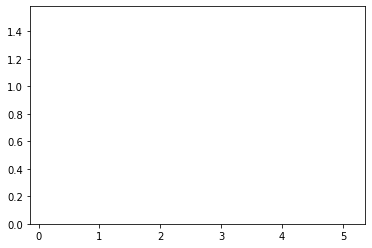

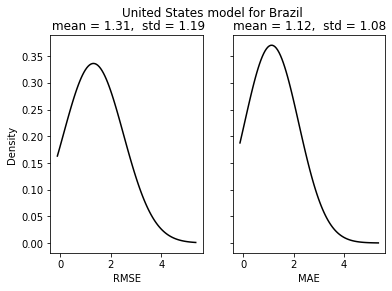

In [ ]:
val_data=newdata['BrazilSMA10']

val_data=val_data.values
univariate_past_history = 20
univariate_future_target = 5

x_val_uni, y_val_uni = univariate_data(val_data, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)
BATCH_SIZE = 110
BUFFER_SIZE = 10

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

for x, y in val_univariate.take(1):
  print (model.predict(x).shape)

k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
rmse=[]
for x, y in val_univariate.take(1):
  forecasts=model.predict(x)           

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  rmse.append(root_mean_squared_error(real,test))
  maxi=np.append(maxi,root_mean_squared_error(real,test)).max()
  mini=np.append(mini,root_mean_squared_error(real,test)).min()
  sumi=sumi+(root_mean_squared_error(real,test))
print(sumi/k)
print(maxi)
print(mini)
print(np.array(rmse).shape)
from scipy.stats import norm
# Fit a normal distribution to the data:

rmse=np.array(rmse)
murmse, stdrmse = norm.fit(rmse)
plt.hist(rmse, bins=25, density=True, alpha=0, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
xre = np.linspace(xmin, xmax, 100)
prmse = norm.pdf(xre, murmse, stdrmse)


from scipy.stats import norm
# Fit a normal distribution to the data:
k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
maee=[]

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  new=tf.keras.metrics.mean_absolute_error(real,test).numpy()
  maee.append(new)
  maxi=np.append(maxi,new).max()
  mini=np.append(mini,new).min()
  sumi=sumi+(new)


mae=np.array(maee)
mumae, stdmae = norm.fit(mae)
plt.hist(mae, bins=25, density=True, alpha=0, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
xme = np.linspace(xmin, xmax, 100)
pmae = norm.pdf(xme, mumae, stdmae)

print(sumi/k)
print(maxi)
print(mini)
print(np.array(maee).shape)


f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,)  
ax1.plot(xre, prmse,'k')  
ax1.set_title('title')  
ax1.set_xlabel('RMSE')
ax1.set_ylabel('Density')
title = " mean = %.2f,  std = %.2f" % (murmse, stdrmse)
ax1.set_title(title)

ax2.plot(xme, pmae,'k') 
ax2.set_xlabel('MAE')
title = "mean = %.2f,  std = %.2f" % (mumae, stdmae)
ax2.set_title(title)
f.suptitle('United States model for Brazil')
f.savefig('brazil.jpg')


(77, 5)
0.9063065585078547
2.6487555305470027
0.2473489344052762
(77,)
0.8038920777571665
2.54071044921875
0.20933981239795685
(77,)


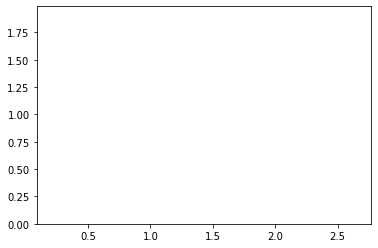

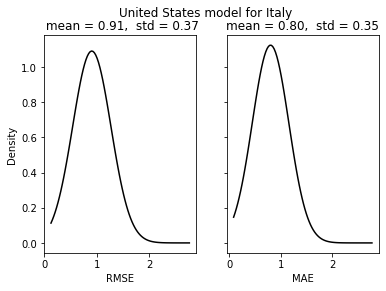

In [ ]:
val_data=newdata['ItalySMA10']

val_data=val_data.values
univariate_past_history = 20
univariate_future_target = 5

x_val_uni, y_val_uni = univariate_data(val_data, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)
BATCH_SIZE = 110
BUFFER_SIZE = 10

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

for x, y in val_univariate.take(1):
  print (model.predict(x).shape)

k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
rmse=[]
for x, y in val_univariate.take(1):
  forecasts=model.predict(x)           

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  rmse.append(root_mean_squared_error(real,test))
  maxi=np.append(maxi,root_mean_squared_error(real,test)).max()
  mini=np.append(mini,root_mean_squared_error(real,test)).min()
  sumi=sumi+(root_mean_squared_error(real,test))
print(sumi/k)
print(maxi)
print(mini)
print(np.array(rmse).shape)
from scipy.stats import norm
# Fit a normal distribution to the data:

rmse=np.array(rmse)
murmse, stdrmse = norm.fit(rmse)
plt.hist(rmse, bins=25, density=True, alpha=0, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
xre = np.linspace(xmin, xmax, 100)
prmse = norm.pdf(xre, murmse, stdrmse)


from scipy.stats import norm
# Fit a normal distribution to the data:
k=77
sumi=0
maxi=np.array([0])
mini=np.array([100])
maee=[]

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  new=tf.keras.metrics.mean_absolute_error(real,test).numpy()
  maee.append(new)
  maxi=np.append(maxi,new).max()
  mini=np.append(mini,new).min()
  sumi=sumi+(new)


mae=np.array(maee)
mumae, stdmae = norm.fit(mae)
plt.hist(mae, bins=25, density=True, alpha=0, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
xme = np.linspace(xmin, xmax, 100)
pmae = norm.pdf(xme, mumae, stdmae)

print(sumi/k)
print(maxi)
print(mini)
print(np.array(maee).shape)


f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,)  
ax1.plot(xre, prmse,'k')  
ax1.set_title('title')  
ax1.set_xlabel('RMSE')
ax1.set_ylabel('Density')
title = " mean = %.2f,  std = %.2f" % (murmse, stdrmse)
ax1.set_title(title)

ax2.plot(xme, pmae,'k') 
ax2.set_xlabel('MAE')
title = "mean = %.2f,  std = %.2f" % (mumae, stdmae)
ax2.set_title(title)
f.suptitle('United States model for Italy') 
f.savefig('italy.jpg')


(15, 5)
0.8106370789159951
0.863319958439377
0.7774223193514674
(15,)
0.632747209072113
0.6818193197250366
0.5957294702529907
(15,)


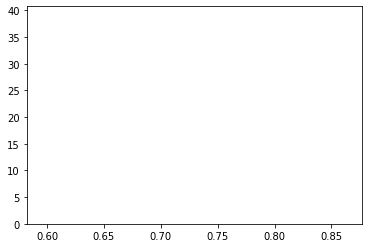

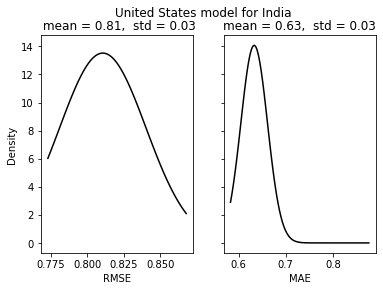

In [ ]:
val_data=newdata['IndiaSMA10'].tail(40)

val_data=val_data.values
univariate_past_history = 20
univariate_future_target = 5

x_val_uni, y_val_uni = univariate_data(val_data, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)
BATCH_SIZE = 110
BUFFER_SIZE = 10

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

for x, y in val_univariate.take(1):
  print (model.predict(x).shape)

k=15
sumi=0
maxi=np.array([0])
mini=np.array([100])
rmse=[]
for x, y in val_univariate.take(1):
  forecasts=model.predict(x)           

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  rmse.append(root_mean_squared_error(real,test))
  maxi=np.append(maxi,root_mean_squared_error(real,test)).max()
  mini=np.append(mini,root_mean_squared_error(real,test)).min()
  sumi=sumi+(root_mean_squared_error(real,test))
print(sumi/k)
print(maxi)
print(mini)
print(np.array(rmse).shape)
from scipy.stats import norm
# Fit a normal distribution to the data:

rmse=np.array(rmse)
murmse, stdrmse = norm.fit(rmse)
plt.hist(rmse, bins=25, density=True, alpha=0, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
xre = np.linspace(xmin, xmax, 100)
prmse = norm.pdf(xre, murmse, stdrmse)


from scipy.stats import norm
# Fit a normal distribution to the data:
k=15
sumi=0
maxi=np.array([0])
mini=np.array([100])
maee=[]

for i in range(k):
  test=forecasts[i]
  real=y[i].numpy()
  new=tf.keras.metrics.mean_absolute_error(real,test).numpy()
  maee.append(new)
  maxi=np.append(maxi,new).max()
  mini=np.append(mini,new).min()
  sumi=sumi+(new)


mae=np.array(maee)
mumae, stdmae = norm.fit(mae)
plt.hist(mae, bins=25, density=True, alpha=0, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
xme = np.linspace(xmin, xmax, 100)
pmae = norm.pdf(xme, mumae, stdmae)

print(sumi/k)
print(maxi)
print(mini)
print(np.array(maee).shape)


f, (ax1, ax2) = plt.subplots(1, 2,sharey=True,)  
ax1.plot(xre, prmse,'k')  
ax1.set_title('title')  
ax1.set_xlabel('RMSE')
ax1.set_ylabel('Density')
title = " mean = %.2f,  std = %.2f" % (murmse, stdrmse)
ax1.set_title(title)

ax2.plot(xme, pmae,'k') 
ax2.set_xlabel('MAE')
title = "mean = %.2f,  std = %.2f" % (mumae, stdmae)
ax2.set_title(title)
f.suptitle('United States model for India')
f.savefig('india.jpg')
